In [1]:
repo_root, *_ = !git rev-parse --show-toplevel
%cd {repo_root}

/mnt/batch/tasks/shared/LS_root/mounts/clusters/rubchume1/code/Users/rubchume/SalesReinforcer


# Setup

## Imports

In [2]:
import functools
from pathlib import Path

import dateparser
import pandas as pd
import plotly.graph_objects as go

from notebooks.eda_tools.graphs.discrete_feature_binary_target import bar

## Utilities

In [13]:
from abc import ABC, abstractmethod
from typing import Callable, Generic, TypeVar


T = TypeVar("ResultType")



class Cache(ABC, Generic[T]):
    def __init__(self, recompute):
        self.recompute = recompute
        
    def __call__(self, function):
        def wrapper(*args, **kwargs):
            key = self.key_generator(*args, **kwargs)
            if not self.recompute and self.is_cached(key):
                return self.load(key)
            
            result = function(*args, **kwargs)
            self.save(key, result)
            return result
        
        return wrapper
    
    @abstractmethod
    def key_generator(self, *args, **kwargs) -> str:
        """Generates cache key from input arguments to function"""
        
    @abstractmethod
    def is_cached(self, key: str) -> bool:
        """Checks if cache key exists"""
        
    @abstractmethod
    def save(self, key: str, result: T):
        """Saves the result with the given cache key"""
        
    @abstractmethod
    def load(self, key: str) -> T:
        """Loads the result associated to the given cache key"""

        
date_columns = [
    "First Contact",
    "Last Contact",
    "First Call",
    "Signed up for a demo",
    "Filled in customer survey",
    "Did sign up to the platform",
    "Account Manager assigned",
    "Subscribed"
]
    
    
class DataFrameCsvCache(Cache[pd.DataFrame]):
    def __init__(self, csv_name, recompute=False):
        self.csv_name = csv_name
        super().__init__(recompute)
        
    def key_generator(self, *args, **kwargs) -> str:
        return self.csv_name
        
    def is_cached(self, key: str) -> bool:
        return Path(self.csv_name).is_file()
        
    def save(self, key: str, result: pd.DataFrame):
        result.to_csv(key, index=False)
        
    def load(self, key: str) -> pd.DataFrame:
        df = pd.read_csv(key)
        df[date_columns] = df[date_columns].apply(pd.to_datetime, axis="index")
        return df
    

# Import and transform data

In [75]:
def clean_date_format(column):
    null_values = ["0000-00-00", "No"]
    column = column.replace(null_values, None)
    column = column.str.replace("20221", "2021")
    return column


def parse_dates(column: pd.Series):
    column_clean_format = clean_date_format(column)
    return column_clean_format.map(dateparser.parse, na_action="ignore")


def clean_country(countries: pd.Series):
    countries = countries.fillna("Unknown").str.lower().str.strip()
    replacements = [
        ("czechia \(czech republic\)", "czechia"),
        ("bulgaria & uk", "bulgaria"),
        ("-", "unknown"),
        ("ca", "california"),
        ("california", "usa"),
        ("chuang", "china"),
        ("full time", "unknown"),
        ("greek", "greece"),
        ("nottingham", "uk"),
        ("philadelphia", "usa"),
        ("russia&ukraine", "russia"),
        ("vietnamese", "vietnam"),
    ]
    
    return functools.reduce(
        lambda countries, replacement: countries.str.replace(fr"^{replacement[0]}$", replacement[1], regex=True),
        replacements,
        countries
    )


@DataFrameCsvCache("data/SalesCRM - CRM (Clean).csv", recompute=False)
def load_data():
    df = pd.read_csv("data/SalesCRM - CRM.csv")
    date_columns = [
        "First Contact",
        "Last Contact",
        "First Call",
        "Signed up for a demo",
        "Filled in customer survey",
        "Did sign up to the platform",
        "Account Manager assigned",
        "Subscribed"
    ]
    df[date_columns] = df[date_columns].apply(parse_dates, axis="index")
    df.Country = clean_country(df.Country)
    df["subscribed"] = (df.Stage == "subscribed already") | (~pd.isnull(df.Subscribed))
    return df


df = load_data()

In [76]:
df.head()

,ID,Country,Education,First Contact,Last Contact,Status,Stage,First Call,Signed up for a demo,Filled in customer survey,Did sign up to the platform,Account Manager assigned,Subscribed,subscribed
0,1,unknown,NaN,NaT,NaT,NaN,NaN,NaT,NaT,NaT,2022-04-27,NaT,NaT,False
1,2,austria,NaN,NaT,NaT,NaN,NaN,2022-04-28,2022-04-25,2022-04-25,2022-04-25,NaT,NaT,False
2,3,united arab emirates,NaN,NaT,NaT,NaN,NaN,NaT,2022-04-24,NaT,NaT,NaT,NaT,False
3,4,france,NaN,NaT,NaT,NaN,NaN,2022-04-22,2022-04-20,2022-04-20,2022-04-22,2022-04-22,NaT,False
4,5,usa,NaN,NaT,NaT,NaN,NaN,2022-04-23,2022-04-19,2022-04-19,NaT,NaT,NaT,False


# Explore demographic data

## Subscribed by country

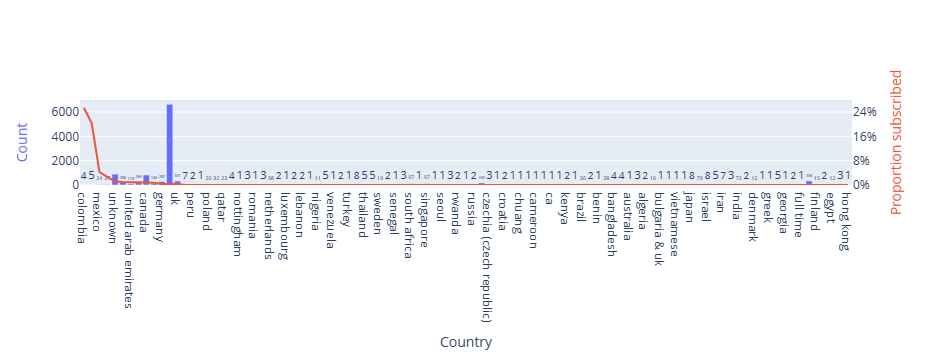

In [21]:
bar(df.Country, df.subscribed, "Country", target_average_name="Proportion subscribed")

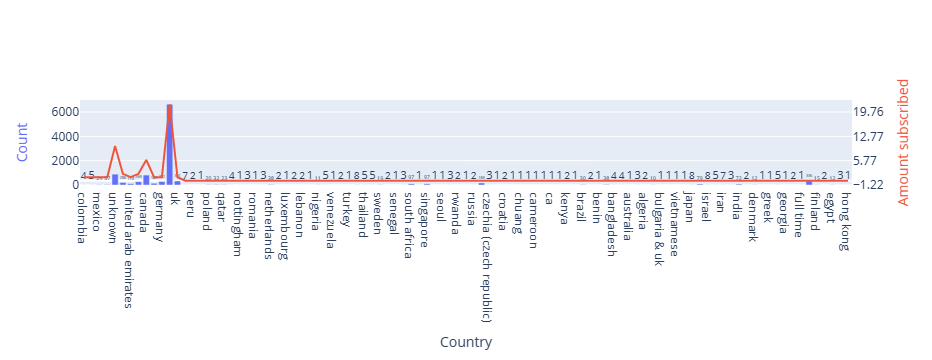

In [22]:
bar(df.Country, df.subscribed, "Country", target_average_name="Amount subscribed", plot_average=False)

## Subscribed by education level

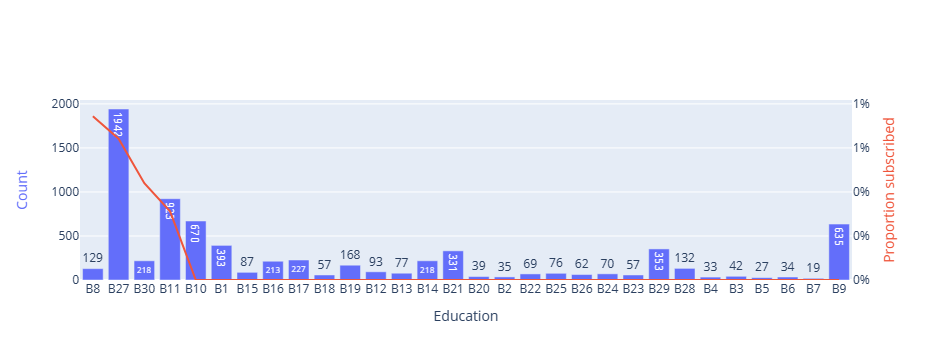

In [24]:
bar(df.Education, df.subscribed, "Education", target_average_name="Proportion subscribed")

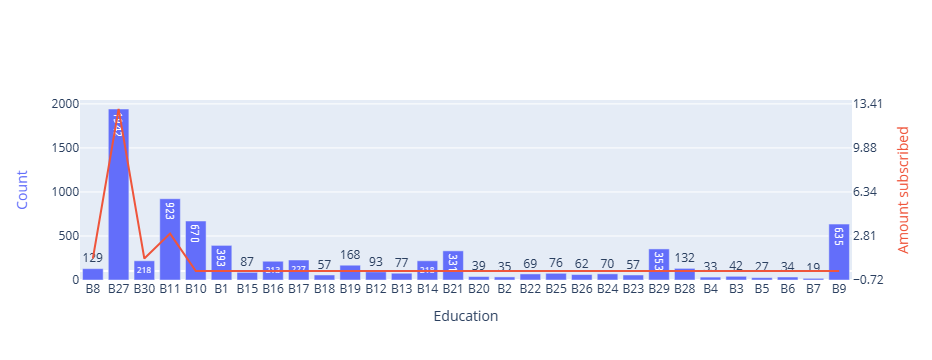

In [25]:
bar(df.Education, df.subscribed, "Education", target_average_name="Amount subscribed", plot_average=False)